<a href="https://colab.research.google.com/github/raunaqnayar/CIFAR10_classification/blob/main/CIFAR10_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using CNN model for classification using Cifar-10 dataset

In [ ]:
from torchvision.datasets import CIFAR10;
import pickle;
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import torch;
import torch.nn as nn;
import torch.nn.functional as F;
from sklearn.model_selection import train_test_split;
from torch.utils.data import TensorDataset,DataLoader;

In [ ]:
cifar10=CIFAR10('sample_data',download=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 63254452.09it/s]


Extracting sample_data/cifar-10-python.tar.gz to sample_data


In [ ]:
cifar10.data.shape

(50000, 32, 32, 3)

In [ ]:
len(cifar10.targets)

50000

In [ ]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
label_info=cifar10.classes

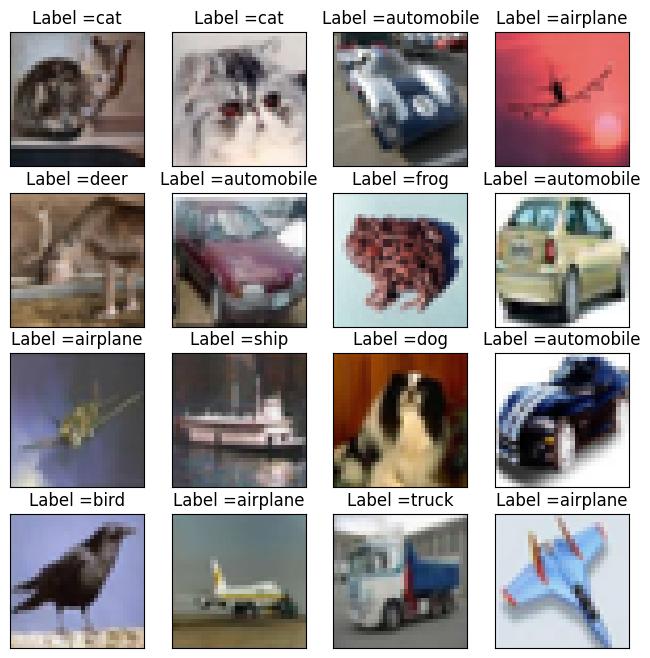

In [ ]:
 val=np.random.choice(range(len(cifar10.targets)),(4,4))

fig,ax=plt.subplots(4,4,figsize=(8,8))
for i in range(4):
  for j in range(4):
    ax[i][j].imshow(cifar10.data[val[i][j],:,:,:])
    #label=label_info[b'label_names'][inp1[b'labels'][val[i][j]]].decode("utf-8")
    ax[i][j].set_title('Label ='+label_info[cifar10.targets[val[i][j]]])
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])

In [ ]:
np.array([1,2,3,4,5,6,7,8,9,10,11,12]).reshape(3,4)

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [ ]:
inp_data=torch.Tensor(np.moveaxis(cifar10.data/255,[1,2,3],[2,3,1]))
target_data=torch.Tensor(cifar10.targets).long()

In [ ]:
inp_data.shape

torch.Size([50000, 3, 32, 32])

In [ ]:
target_data.shape

torch.Size([50000])

## Create CNN architecture for CIFAR10

In [ ]:
def create_cifar10_CNN(channels1,channels2,channels3,l2_param=0):
  class cifar10_classifier(nn.Module):
    def __init__(self):
      super().__init__();
      self.input_conv=nn.Conv2d(3,channels1,kernel_size=5,stride=1,padding=1)
      self.input_maxpool=nn.MaxPool2d((2,2),stride=2)
      self.hidden1_batchnorm=nn.BatchNorm2d(channels1)
      self.hidden1_conv=nn.Conv2d(channels1,channels2,kernel_size=5,stride=1,padding=1)
      self.hidden1_maxpool=nn.MaxPool2d((2,2),stride=2)
      self.hidden2_batchnorm=nn.BatchNorm2d(channels2)
      self.hidden2_conv=nn.Conv2d(channels2,channels3,kernel_size=5,stride=1,padding=1)
      self.hidden2_maxpool=nn.MaxPool2d((2,2),stride=2)
      self.hidden3_batchnorm=nn.BatchNorm1d(channels3*2*2)
      self.fc1=nn.Linear(channels3*2*2,200);
      self.fc1_batchnorm=nn.BatchNorm1d(200);
      self.output=nn.Linear(200,10);
    def forward(self,x):
      x=F.relu(self.input_maxpool(self.input_conv(x)));
      x=F.relu(self.hidden1_maxpool(self.hidden1_conv(self.hidden1_batchnorm(x))));
      x=F.relu(self.hidden2_maxpool(self.hidden2_conv(self.hidden2_batchnorm(x))));
      x=x.view(x.shape[0],-1)
      x=F.relu(self.fc1(self.hidden3_batchnorm(x)));
      y=self.output(self.fc1_batchnorm(x))
      return y
  model=cifar10_classifier();
  lossfun=nn.CrossEntropyLoss();
  optimizer=torch.optim.Adam(model.parameters(),lr=0.002,weight_decay=l2_param);
  return model,lossfun,optimizer;

#### Check if the architecture is correct

In [ ]:
temp=create_cifar10_CNN(64,128,256)[0]
temp(torch.randn([7,3,32,32])).shape

torch.Size([7, 10])

## Train the CIFAR-10 data on the created CNN model

In [ ]:
X_train,X_valtest,y_train,y_valtest=train_test_split(inp_data,target_data,test_size=0.2);
X_val,X_test,y_val,y_test=train_test_split(X_valtest,y_valtest,test_size=0.5);
train_dataset=TensorDataset(X_train,y_train);
val_dataset=TensorDataset(X_val,y_val);
test_dataset=TensorDataset(X_test,y_test);
train_dataset=DataLoader(train_dataset,batch_size=64,shuffle=True);
val_dataset=DataLoader(val_dataset,batch_size=val_dataset.tensors[0].shape[0]);
test_dataset=DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0]);

In [ ]:
def train_cifar10(channels1,channels2,channels3,l2_param=0):

  device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu');

  CNN_model, lossfun, optimizer=create_cifar10_CNN(channels1,channels2,channels3,l2_param);



  num_epochs=10;
  trainLoss=np.zeros(num_epochs);
  trainAcc=np.zeros(num_epochs);
  testLoss=np.zeros(num_epochs);
  testAcc=np.zeros(num_epochs);

  for i in range(num_epochs):
    batchLoss=[];
    batchAcc=[];
    CNN_model.train();
    CNN_model.to(device);

    for X,y in train_dataset:
      X=X.to(device);
      y=y.to(device);
      yHat=CNN_model(X);
      loss=lossfun(yHat,y)
      optimizer.zero_grad();
      loss.backward();
      optimizer.step();
      batchLoss.append(loss.detach().cpu().item());
      batchAcc.append((torch.mean((torch.argmax(yHat.detach().cpu(),dim=1)==y.cpu()).float())*100).item());
    trainLoss[i]=np.mean(batchLoss)
    trainAcc[i]=np.mean(batchAcc)
    CNN_model.eval();
    with torch.no_grad():
      X,y=next(iter(val_dataset))
      X=X.to(device);
      y=y.to(device);
      yHat=CNN_model(X);
      loss=lossfun(yHat,y)
      testLoss[i]=loss.detach().cpu().item();
      testAcc[i]=((torch.mean((torch.argmax(yHat.detach().cpu(),dim=1)==y.cpu()).float())*100).item());

  return CNN_model,trainLoss,trainAcc,testLoss,testAcc


In [ ]:
#avg_train_loss=[];
#avg_val_loss=[];
#avg_train_acc=[];
#avg_val_acc=[];
#for ch2 in [100,128,150,175,200]:
#  cifar10_model, trainLoss,trainAcc,valLoss,valAcc = train_cifar10(64,ch2,256,l2_param=0.0003);
#  avg_train_loss.append(np.mean(trainLoss[-5:]))
#  avg_val_loss.append(np.mean(valLoss[-5:]))
#  avg_train_acc.append(np.mean(trainAcc[-5:]))
#  avg_val_acc.append(np.mean(valAcc[-5:]))
#  print(ch2)

In [ ]:
#fig,ax=plt.subplots(1,2,figsize=(20,6))
#ax[0].plot([100,128,150,175,200],avg_train_loss,'r')
#ax[0].plot([100,128,150,175,200],avg_val_loss,'b')
#ax[0].legend(['Train','Test'])

#ax[0].set_xlabel('channel 2')
#ax[0].set_ylabel('Loss')
#ax[1].plot([100,128,150,175,200],avg_train_acc,'r')
#ax[1].plot([100,128,150,175,200],avg_val_acc,'b')
#ax[1].legend(['Train','Test'])
#ax[1].set_xlabel('channel 2')
#ax[1].set_ylabel('Accuracy(%)')



In [ ]:
final_cifar10_model, trainLoss,trainAcc,valLoss,valAcc = train_cifar10(64,128,256,l2_param=0.0003);

In [ ]:
final_cifar10_model.eval()
with torch.no_grad():
  X,y=next(iter(test_dataset))
  X=X.to(device);
  y=y.to(device);
  yHat=final_cifar10_model(X);
testAcc=(torch.mean((torch.argmax(yHat.detach().cpu(),dim=1)==y.cpu()).float())*100).item()
testAcc

68.80000305175781

Text(0, 0.5, 'Accuracy(%)')

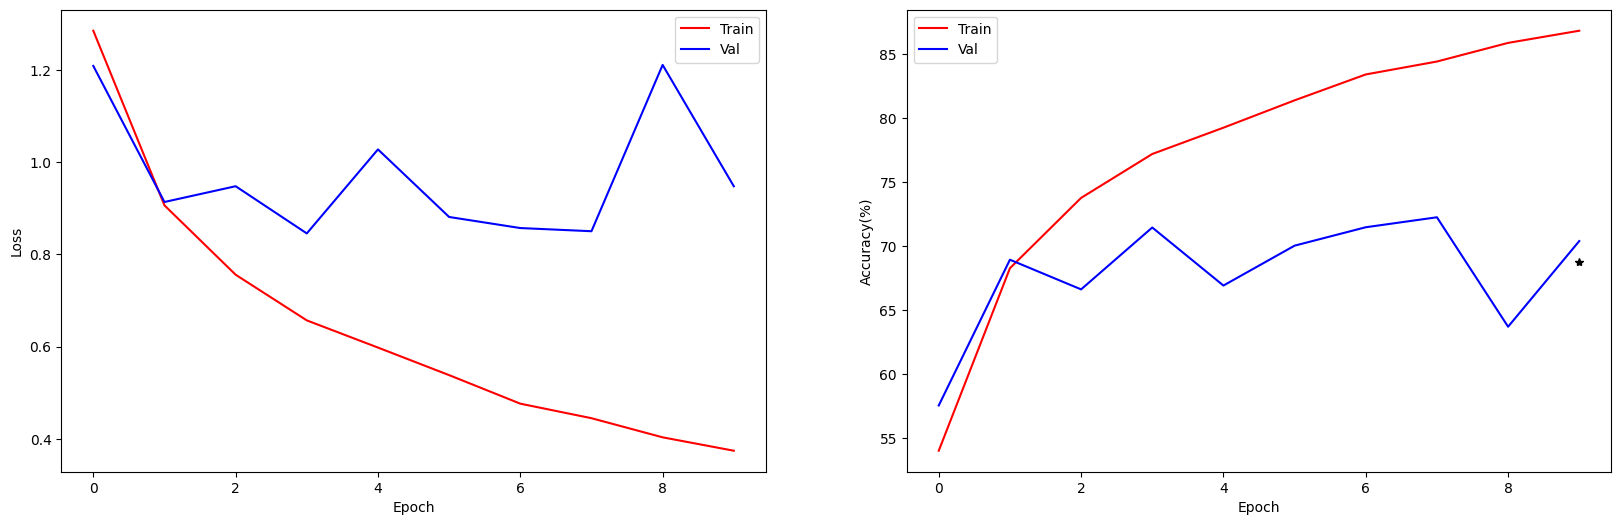

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(20,6))
ax[0].plot(range(10),trainLoss,'r')
ax[0].plot(range(10),valLoss,'b')
ax[0].legend(['Train','Val'])

ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(range(10),trainAcc,'r')
ax[1].plot(range(10),valAcc,'b')
ax[1].plot(9,testAcc,'k*')
ax[1].legend(['Train','Val'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy(%)')

In [ ]:
print("CIFAR10 dataset has total 10 categories:")
print("Training Accuracy (40000 images) is:",trainAcc[-1])
print("Validation Accuracy (5000 images) is: ",valAcc[-1])
print("Test Batch Accuracy (5000 images) is: ",testAcc)

CIFAR10 dataset has total 10 categories:
Training Accuracy (40000 images) is: 86.8525
Validation Accuracy (5000 images) is:  70.4000015258789
Test Batch Accuracy (5000 images) is:  68.80000305175781
